In [47]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import scipy.stats as stats
from IPython.display import display
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import cross_val_predict
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [48]:
hmeq=pd.read_csv(r"C:\Users\chemm\Desktop\cours\MOSEF\Python\Exercice\Scoring\Projet_scoring\data\hmeq.csv")
hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [49]:
description = hmeq.describe()
print("Statistiques descriptives :\n", description)

Statistiques descriptives :
                BAD          LOAN        MORTDUE          VALUE          YOJ  \
count  5960.000000   5960.000000    5442.000000    5848.000000  5445.000000   
mean      0.199497  18607.969799   73760.817200  101776.048741     8.922268   
std       0.399656  11207.480417   44457.609458   57385.775334     7.573982   
min       0.000000   1100.000000    2063.000000    8000.000000     0.000000   
25%       0.000000  11100.000000   46276.000000   66075.500000     3.000000   
50%       0.000000  16300.000000   65019.000000   89235.500000     7.000000   
75%       0.000000  23300.000000   91488.000000  119824.250000    13.000000   
max       1.000000  89900.000000  399550.000000  855909.000000    41.000000   

             DEROG       DELINQ        CLAGE         NINQ         CLNO  \
count  5252.000000  5380.000000  5652.000000  5450.000000  5738.000000   
mean      0.254570     0.449442   179.766275     1.186055    21.296096   
std       0.846047     1.127266    85


Skewness des variables :
 LOAN       2.023781
MORTDUE    1.814481
VALUE      3.053344
YOJ        0.988460
DEROG      5.320870
DELINQ     4.023150
CLAGE      1.343412
NINQ       2.621984
CLNO       0.775052
DEBTINC    2.852353
dtype: float64

Kurtosis des variables :
 LOAN        6.932590
MORTDUE     6.481866
VALUE      24.362805
YOJ         0.372072
DEROG      36.872763
DELINQ     23.565449
CLAGE       7.599549
NINQ        9.786507
CLNO        1.157673
DEBTINC    50.504042
dtype: float64


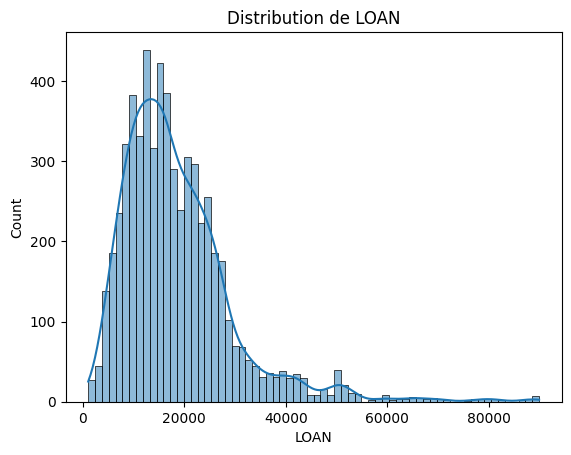

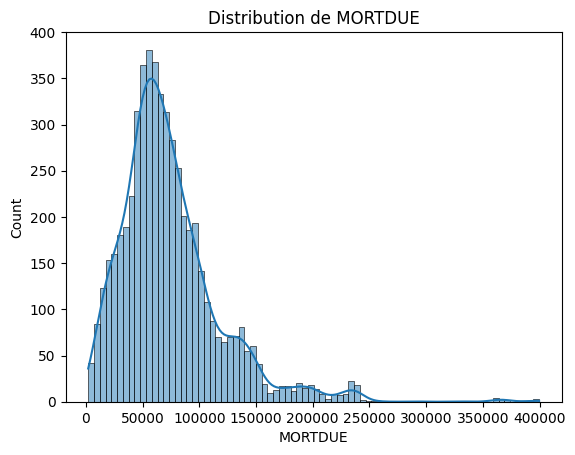

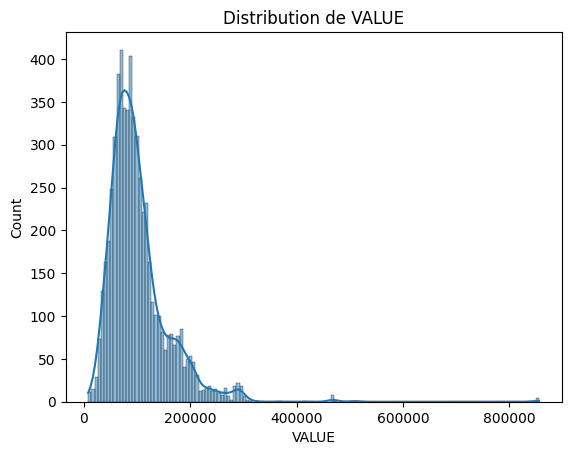

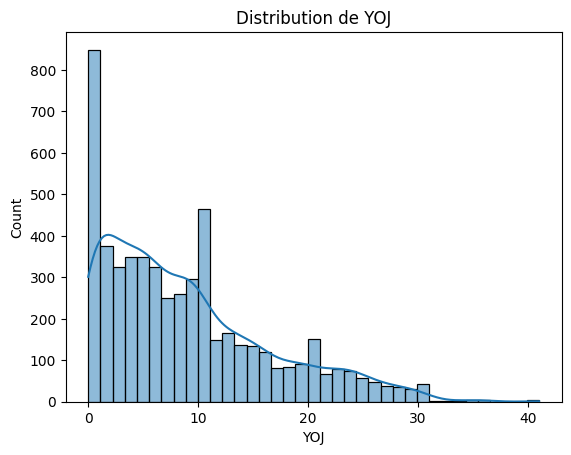

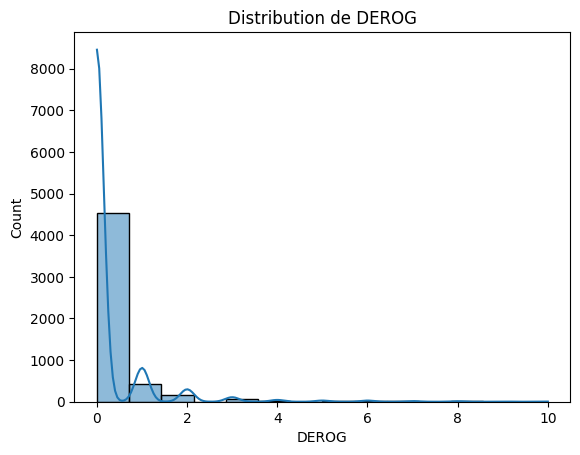

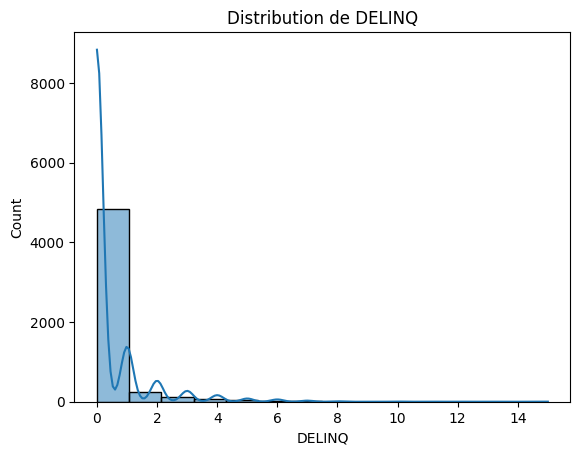

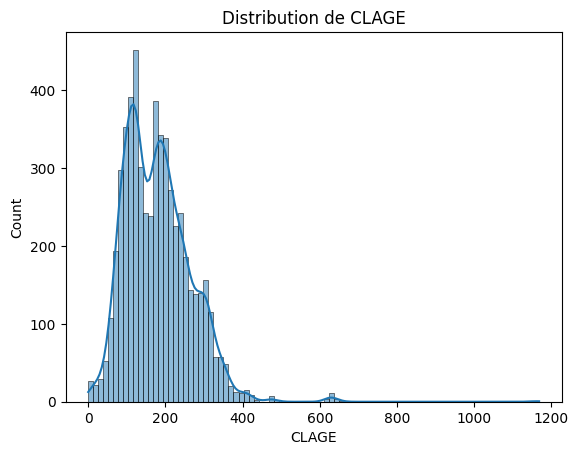

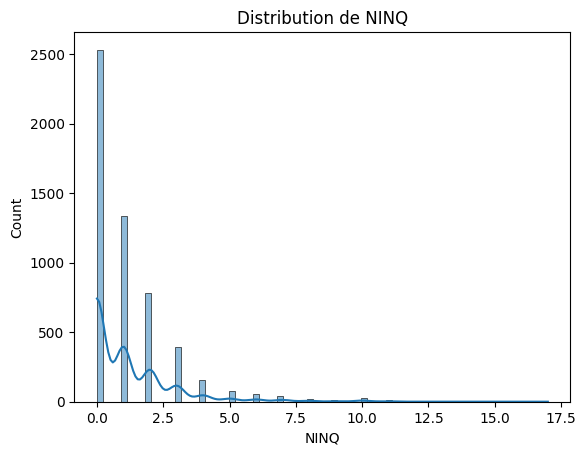

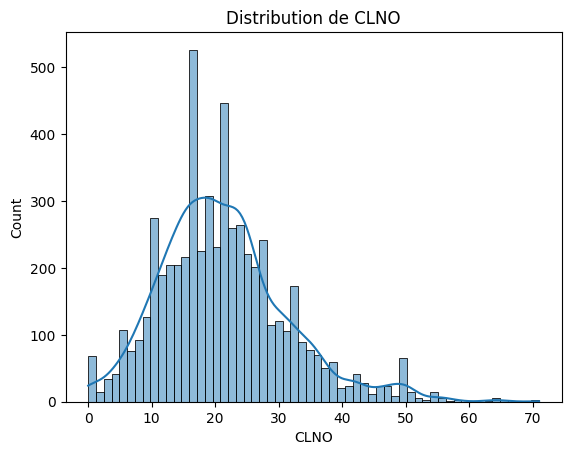

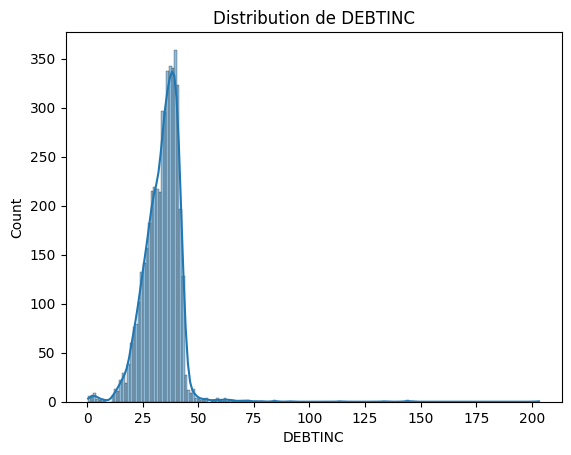

In [50]:
numeric_columns = ['LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

skewness = hmeq[numeric_columns].skew()
kurtosis = hmeq[numeric_columns].kurtosis()
print("\nSkewness des variables :\n", skewness)
print("\nKurtosis des variables :\n", kurtosis)

for col in numeric_columns:
    plt.figure()
    sns.histplot(hmeq[col].dropna(), kde=True)
    plt.title(f'Distribution de {col}')
    plt.show()

# Imputation des donnees avec la mediane/freq

In [20]:
from sklearn.impute import SimpleImputer

# Séparation des colonnes numériques et catégorielles
numeric_columns = hmeq.select_dtypes(include=[np.number]).drop(columns=['BAD'])
categorical_columns = hmeq.select_dtypes(include=['object'])

# Imputation des valeurs manquantes numériques (par la médiane)
imputer_num = SimpleImputer(strategy='median')
hmeq[numeric_columns.columns] = imputer_num.fit_transform(numeric_columns)

# Imputation des valeurs manquantes catégorielles (par la valeur la plus fréquente)
imputer_cat = SimpleImputer(strategy='most_frequent')
hmeq[categorical_columns.columns] = imputer_cat.fit_transform(categorical_columns)

# Vérifier qu'il ne reste plus de valeurs manquantes
print(hmeq.isnull().sum())


BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64


In [21]:
# from sklearn.neighbors import LocalOutlierFactor
# import numpy as np

# # Sélection des variables numériques pour détecter les outliers
# numeric_columns = hmeq.select_dtypes(include=[np.number]).drop(columns=['BAD'])

# # Appliquer LOF
# lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Ajustez "n_neighbors" et "contamination" selon les besoins
# outliers = lof.fit_predict(numeric_columns)

# # Ajouter une colonne "outliers" au dataframe
# hmeq['LOF_Outlier'] = np.where(outliers == -1, 1, 0)

# # Afficher les résultats
# print(hmeq['LOF_Outlier'].value_counts())
# hmeq[hmeq['LOF_Outlier'] == 1]


# Gestion des outliers

In [22]:
from sklearn.ensemble import IsolationForest

# Appliquer Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)  # Ajustez "contamination" selon les besoins
outliers = iso_forest.fit_predict(numeric_columns)

# Ajouter une colonne "outliers" au dataframe
hmeq['IsoForest_Outlier'] = np.where(outliers == -1, 1, 0)

# Afficher les résultats
print(hmeq['IsoForest_Outlier'].value_counts())
hmeq[hmeq['IsoForest_Outlier'] == 1]


IsoForest_Outlier
0    5662
1     298
Name: count, dtype: int64


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,IsoForest_Outlier
6,1,1800.0,48649.0,57037.0,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,34.818262,1
16,1,2200.0,90957.0,102600.0,HomeImp,Mgr,7.0,2.0,6.0,122.900000,1.0,22.0,34.818262,1
31,1,2800.0,50795.0,63100.0,HomeImp,Self,26.0,2.0,15.0,145.633333,3.0,45.0,34.818262,1
32,1,2800.0,4000.0,60850.0,HomeImp,Other,16.0,4.0,0.0,112.633333,2.0,9.0,34.818262,1
36,1,2900.0,7750.0,67996.0,HomeImp,Other,16.0,3.0,0.0,122.204663,2.0,8.0,36.211348,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5938,0,79200.0,21694.0,103143.0,HomeImp,Other,26.0,0.0,1.0,139.938999,0.0,14.0,31.333685,1
5939,0,79200.0,22940.0,110114.0,HomeImp,Other,28.0,0.0,1.0,144.616126,0.0,13.0,32.366512,1
5940,0,79900.0,18363.0,109675.0,HomeImp,Other,27.0,0.0,1.0,132.766724,0.0,13.0,31.642335,1
5941,0,80300.0,20370.0,109127.0,HomeImp,Other,27.0,0.0,1.0,142.174300,0.0,13.0,33.468763,1


In [25]:
# Suppression des outliers
hmeq_cleaned = hmeq[hmeq['IsoForest_Outlier'] == 0]

# Vérifier la taille du dataset après suppression des outliers
print(f"Taille du dataset initial : {hmeq.shape[0]}")
print(f"Taille du dataset après suppression des outliers : {hmeq_cleaned.shape[0]}")

# Optionnel : Visualisation des distributions après suppression des outliers
hmeq_cleaned.describe()

# Continuer avec l'analyse ou modélisation sur le dataset nettoyé


Taille du dataset initial : 5960
Taille du dataset après suppression des outliers : 5662


,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,IsoForest_Outlier
count,5662.000000,5662.000000,5662.000000,5662.000000,5662.000000,5662.000000,5662.000000,5662.000000,5662.000000,5662.000000,5662.000000,5662.0
mean,0.177676,18109.272342,70328.246591,98847.536478,8.746953,0.134581,0.318969,178.843049,1.079124,20.869657,33.929268,0.0
std,0.382273,10519.827791,36015.483058,49917.148968,7.183150,0.458381,0.874570,82.940416,1.509468,9.404846,7.320189,0.0
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499,0.0
25%,0.000000,11000.000000,48094.750000,66612.750000,3.000000,0.000000,0.000000,117.163028,0.000000,15.000000,30.691188,0.0
50%,0.000000,16100.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,173.466667,1.000000,20.000000,34.818262,0.0
75%,0.000000,22800.000000,86000.000000,117622.000000,12.000000,0.000000,0.000000,225.621441,1.000000,26.000000,37.950489,0.0
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,5.000000,12.000000,1168.233561,17.000000,65.000000,203.312149,0.0


# Premier test de RegLOG

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Supposons que 'hmeq_cleaned' soit votre dataset nettoyé, sans valeurs manquantes ni outliers

# 1. Encodage des variables catégorielles
categorical_features = ['REASON', 'JOB']
hmeq_encoded = pd.get_dummies(hmeq_cleaned, columns=categorical_features, drop_first=True)

# 2. Séparation des variables explicatives et de la cible
X = hmeq_encoded.drop(columns=['BAD'])
y = hmeq_encoded['BAD']

# 3. Division en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Ajuster la régression logistique
log_reg = LogisticRegression(max_iter=100000)  # Augmentez 'max_iter' si nécessaire
log_reg.fit(X_train, y_train)

# 5. Prédictions
y_pred = log_reg.predict(X_test)

# 6. Évaluation du modèle
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("Classification report :\n", classification_report(y_test, y_pred))

# 7. Courbe ROC et AUC
y_prob = log_reg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

print(f"AUC : {roc_auc}")


Matrice de confusion :
 [[1362   29]
 [ 237   71]]
Classification report :
               precision    recall  f1-score   support

           0       0.85      0.98      0.91      1391
           1       0.71      0.23      0.35       308

    accuracy                           0.84      1699
   macro avg       0.78      0.60      0.63      1699
weighted avg       0.83      0.84      0.81      1699

AUC : 0.7825772358482639


C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Séparer les variables explicatives (X) et la cible (y)
X = hmeq_encoded.drop(columns=['BAD'])
y = hmeq_encoded['BAD']

# 2. Diviser les données en jeu d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Appliquer SMOTE pour rééquilibrer les classes dans le jeu d'entraînement
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 4. Réajuster le modèle de régression logistique sur les données équilibrées
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train_smote, y_train_smote)

# 5. Faire des prédictions sur le jeu de test
y_pred = log_reg.predict(X_test)

# 6. Évaluer les performances du modèle
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
print("Classification report :\n", classification_report(y_test, y_pred))

# 7. Calculer l'AUC
y_prob = log_reg.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
print(f"AUC : {roc_auc}")


Matrice de confusion :
 [[1087  304]
 [ 112  196]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.78      0.84      1391
           1       0.39      0.64      0.49       308

    accuracy                           0.76      1699
   macro avg       0.65      0.71      0.66      1699
weighted avg       0.81      0.76      0.78      1699

AUC : 0.7769310129123215


C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import LogisticRegression

# # Paramètres à tester avec Grid Search
# param_grid = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Paramètre de régularisation
#     'penalty': ['l1', 'l2'],  # Type de pénalité
#     'solver': ['liblinear', 'saga'],  # Solvers qui supportent l1 et l2
#     'max_iter': [1000]  # Pour éviter les problèmes de convergence
# }

# # Créer un modèle de régression logistique
# log_reg = LogisticRegression()

# # Configurer Grid Search
# grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)

# # Exécuter Grid Search sur les données rééchantillonnées (après SMOTE)
# grid_search.fit(X_train_smote, y_train_smote)

# # Meilleurs hyperparamètres trouvés
# print("Meilleurs hyperparamètres :\n", grid_search.best_params_)

# # Réentraîner le modèle avec les meilleurs hyperparamètres sur l'ensemble de données équilibré
# best_model = grid_search.best_estimator_
# best_model.fit(X_train_smote, y_train_smote)

# # Évaluation sur le jeu de test
# y_pred = best_model.predict(X_test)

# # Matrice de confusion et rapport de classification
# print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
# print("Classification report :\n", classification_report(y_test, y_pred))

# # Calcul de l'AUC
# y_prob = best_model.predict_proba(X_test)[:, 1]
# roc_auc = roc_auc_score(y_test, y_prob)
# print(f"AUC : {roc_auc}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\chemm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

Meilleurs hyperparamètres :
 {'C': 1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Matrice de confusion :
 [[1136  255]
 [ 133  175]]
Classification report :
               precision    recall  f1-score   support

           0       0.90      0.82      0.85      1391
           1       0.41      0.57      0.47       308

    accuracy                           0.77      1699
   macro avg       0.65      0.69      0.66      1699
weighted avg       0.81      0.77      0.79      1699

AUC : 0.7510036692279684


Seuil de décision ajusté : 0.4
Matrice de confusion :
 [[981 410]
 [ 96 212]]
Classification report :
               precision    recall  f1-score   support

           0       0.91      0.71      0.79      1391
           1       0.34      0.69      0.46       308

    accuracy                           0.70      1699
   macro avg       0.63      0.70      0.63      1699
weighted avg       0.81      0.70      0.73      1699

AUC : 0.7510830291204122


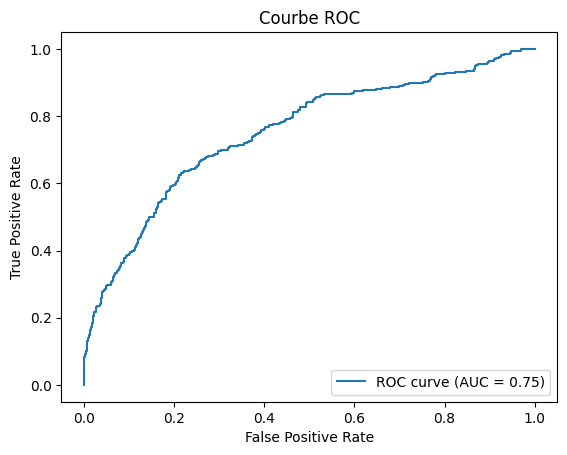

In [41]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# # Modèle avec les hyperparamètres optimaux trouvés avec Grid Search
# log_reg_opt = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=1000)

# # Entraîner le modèle sur les données équilibrées (après SMOTE)
# log_reg_opt.fit(X_train_smote, y_train_smote)

# # Prédiction des probabilités sur le jeu de test
# y_prob = log_reg_opt.predict_proba(X_test)[:, 1]  # Probabilité d'appartenir à la classe 1 (BAD=1)

# # Ajuster le seuil de décision (par exemple, seuil = 0.4)
# threshold = 0.4
# y_pred_adjusted = (y_prob >= threshold).astype(int)

# # Évaluation des performances avec le seuil ajusté
# print(f"Seuil de décision ajusté : {threshold}")
# print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_adjusted))
# print("Classification report :\n", classification_report(y_test, y_pred_adjusted))

# # Calcul de l'AUC
# roc_auc = roc_auc_score(y_test, y_prob)
# print(f"AUC : {roc_auc}")

# # Optionnel : Tracer la courbe ROC pour analyser le compromis entre rappel et précision
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)
# plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Courbe ROC')
# plt.legend(loc="lower right")
# plt.show()


Meilleur seuil basé sur le F1-score : 0.4739988610148502
F1-score avec ce seuil : 0.4842370744010088


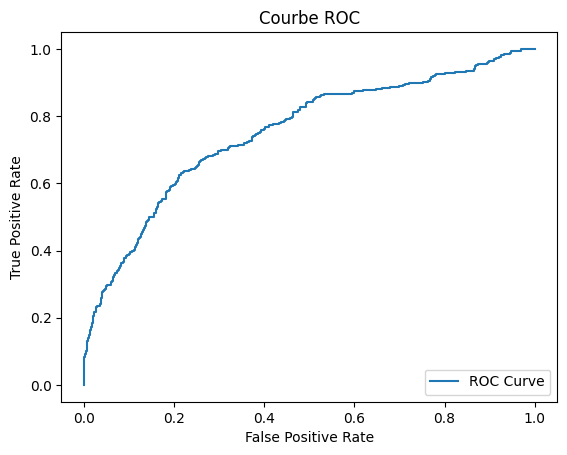

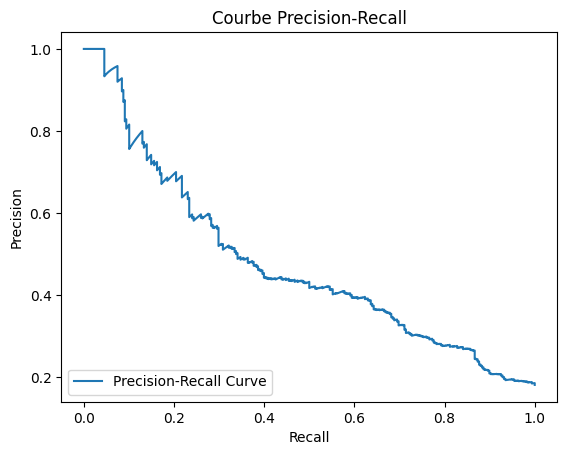

In [42]:
# import numpy as np
# from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

# # Calculer les probabilités de la classe 1 (défaillant)
# y_prob = log_reg_opt.predict_proba(X_test)[:, 1]

# # Calculer la courbe ROC pour obtenir différents seuils
# fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# # Calculer la courbe Precision-Recall
# precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)

# # Initialiser des variables pour stocker les meilleurs résultats
# best_threshold = 0
# best_f1 = 0

# # Tester chaque seuil et calculer le F1-score pour chaque seuil
# for threshold in pr_thresholds:
#     y_pred_adjusted = (y_prob >= threshold).astype(int)
#     f1 = f1_score(y_test, y_pred_adjusted)
#     if f1 > best_f1:
#         best_f1 = f1
#         best_threshold = threshold

# print(f"Meilleur seuil basé sur le F1-score : {best_threshold}")
# print(f"F1-score avec ce seuil : {best_f1}")

# # Optionnel : Visualiser la courbe ROC ou Precision-Recall
# import matplotlib.pyplot as plt

# # Courbe ROC
# plt.plot(fpr, tpr, label="ROC Curve")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Courbe ROC")
# plt.legend(loc="lower right")
# plt.show()

# # Courbe Precision-Recall
# plt.plot(recall, precision, label="Precision-Recall Curve")
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Courbe Precision-Recall")
# plt.legend(loc="lower left")
# plt.show()


# Tests d'autre chose: